# Step 2: Birds calls classification model training

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image as im
from tqdm import tqdm
import sklearn
import random

In [2]:
target = ['redcro', 'comrav', 'houspa', 'norcar', 'barswa', 'houwre', 'sonspa',
       'gbwwre1', 'eursta', 'spotow', 'cubthr', 'rewbla', 'mallar3', 'amerob',
       'bewwre', 'carwre', 'swathr', 'rubpep1', 'bncfly', 'rucspa1']

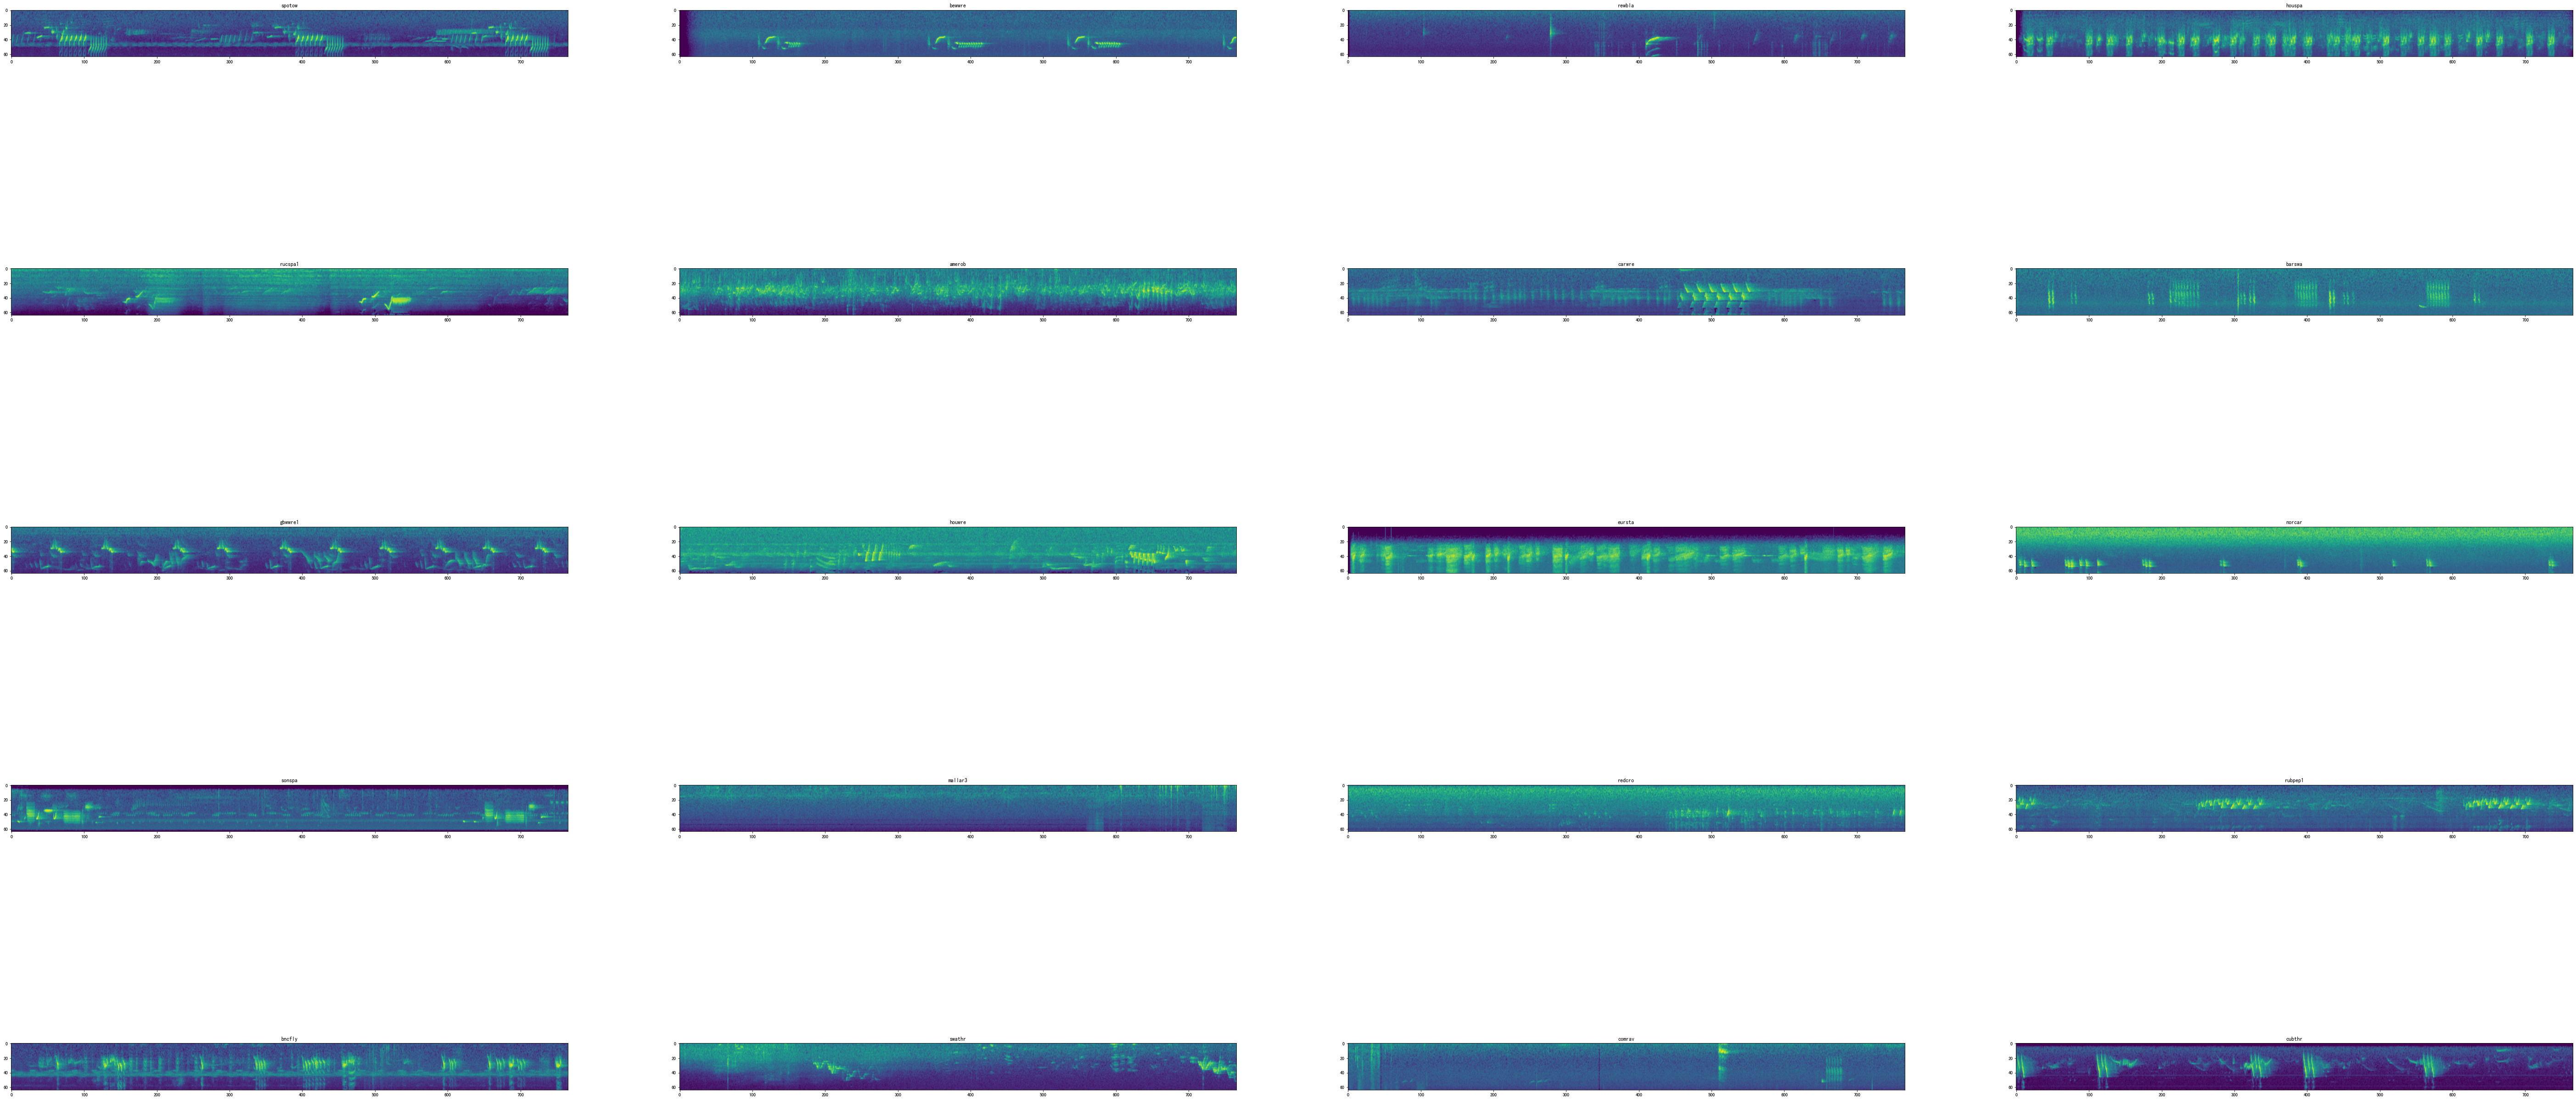

In [3]:
## show the first 20 types of birds' images 
inputs = ('/input0/')
plt.figure(figsize=(100,50))
count = 0
for bird in os.listdir(inputs):
    if bird in target:
        if bird.startswith("."):
            continue
        pic = im.open(inputs+bird+"/"+os.listdir(inputs+bird+"/")[0])
        plt.subplot(5, 4, count + 1)
        plt.title(bird)
        plt.imshow(pic)
        count += 1

In [7]:
features, labels = [], []
for bird in target:
    if bird.startswith("."):
        continue
    with tqdm(total=len(os.listdir(inputs+bird+"/"))) as loading:
        for image in os.listdir(inputs+bird+"/"):
            loading.update(1)
            fea_mtx = im.open(inputs+bird+"/"+image)
            fea_mtx = np.array(fea_mtx)
            fea_mtx = fea_mtx.astype("float32")
            fea_mtx = np.expand_dims(fea_mtx,-1)
            label_m = np.zeros(len(target), dtype="float32")
            if fea_mtx.max() == 0.0:
                features.append(fea_mtx)
                labels.append(label_m)
                continue
            
            fea_mtx -= fea_mtx.min()
            fea_mtx /= fea_mtx.max()
            label_m[target.index(bird)] = 1.0
            features.append(fea_mtx)
            labels.append(label_m)

            comb = list(zip(features, labels))
random.shuffle(comb)
features, labels = zip(*comb)
features = np.array(features)
labels = np.array(labels)

100%|██████████| 918/918 [00:23<00:00, 39.32it/s]


In [8]:
np.save("features.npy",features)
np.save("labels.npy", labels)

In [4]:
features = np.load("features.npy")
labels = np.load("labels.npy")
print(features.shape)
print(labels.shape)

(34887, 64, 766, 1)
(34887, 20)


# Models

In [6]:
tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.list_logical_devices('GPU')

## Resnet

In [10]:
resnet = tf.keras.applications.resnet_v2.ResNet152V2(include_top=True,
                                                     weights=None,
                                                     input_tensor=None,
                                                     input_shape=(64,766,1),
                                                     classes=20,
                                                     classifier_activation="softmax")
resnet.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=["acc", tf.keras.metrics.Accuracy()])

In [11]:
log_path = './tf_dir/resNet'
res_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path)
history = resnet.fit(x=features[:30001],             
                    y=labels[:30001], 
                    batch_size=16, 
                    epochs=20, 
                    validation_data=(features[30001:], labels[30001:]),
                    callbacks=[res_callback])

Epoch 1/20
1876/1876 [==============================] - 271s 145ms/step - loss: 1.8703 - acc: 0.4540 - accuracy: 1.6666e-06 - val_loss: 2.4197 - val_acc: 0.4488 - val_accuracy: 5.8330e-04
Epoch 2/20
1876/1876 [==============================] - 267s 142ms/step - loss: 1.1222 - acc: 0.6963 - accuracy: 2.1666e-05 - val_loss: 1.3403 - val_acc: 0.6658 - val_accuracy: 9.5170e-04
Epoch 3/20
1876/1876 [==============================] - 267s 142ms/step - loss: 0.8303 - acc: 0.7827 - accuracy: 2.6666e-05 - val_loss: 1.1412 - val_acc: 0.6856 - val_accuracy: 3.0700e-05
Epoch 4/20
1876/1876 [==============================] - 266s 142ms/step - loss: 0.7325 - acc: 0.8104 - accuracy: 3.4999e-05 - val_loss: 0.9554 - val_acc: 0.7724 - val_accuracy: 6.0377e-04
Epoch 5/20
1876/1876 [==============================] - 266s 142ms/step - loss: 0.5754 - acc: 0.8579 - accuracy: 8.6664e-05 - val_loss: 0.6223 - val_acc: 0.8492 - val_accuracy: 6.5493e-04
Epoch 6/20
1876/1876 [==============================] - 266s

In [12]:
resnet.evaluate(x=features, y=labels)

1091/1091 [==============================] - 80s 73ms/step - loss: 0.1823 - acc: 0.9777 - accuracy: 5.7328e-06


[0.18225091695785522, 0.9776994585990906, 5.7327943068230525e-06]

In [13]:
resnet.save("/output/res_model")

INFO:tensorflow:Assets written to: /output/res_model/assets


## mobile-Net-V2

In [5]:
mobile_net_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=True,
                                              weights=None,
                                              input_tensor=None,
                                              input_shape=(64,766,1),
                                              classes=20)
mobile_net_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=["acc", tf.keras.metrics.Accuracy()])

In [6]:
log_path = './tf_dir/mobileNet'
mobile_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, write_images=True)
history = mobile_net_model.fit(x=features[:30001],             
                               y=labels[:30001], 
                               batch_size=16, 
                               epochs=20, 
                               validation_data=(features[30001:], labels[30001:]),
                               callbacks=[mobile_callback])

Epoch 1/20
1876/1876 [==============================] - 134s 72ms/step - loss: 1.6490 - acc: 0.5250 - accuracy: 0.0000e+00 - val_loss: 3.9384 - val_acc: 0.0485 - val_accuracy: 0.0000e+00
Epoch 2/20
1876/1876 [==============================] - 132s 70ms/step - loss: 1.0252 - acc: 0.7204 - accuracy: 0.0000e+00 - val_loss: 3.4958 - val_acc: 0.0508 - val_accuracy: 0.0000e+00
Epoch 3/20
1876/1876 [==============================] - 125s 67ms/step - loss: 0.8181 - acc: 0.7868 - accuracy: 9.9997e-06 - val_loss: 2.0908 - val_acc: 0.6132 - val_accuracy: 0.0012
Epoch 4/20
1876/1876 [==============================] - 131s 70ms/step - loss: 0.6830 - acc: 0.8264 - accuracy: 8.3331e-06 - val_loss: 3.5280 - val_acc: 0.5295 - val_accuracy: 0.0031
Epoch 5/20
1876/1876 [==============================] - 132s 70ms/step - loss: 0.5969 - acc: 0.8531 - accuracy: 2.4999e-05 - val_loss: 4.4479 - val_acc: 0.5096 - val_accuracy: 0.0021
Epoch 6/20
1876/1876 [==============================] - 124s 66ms/step - loss

In [7]:
mobile_net_model.evaluate(x=features, y=labels)

1091/1091 [==============================] - 17s 16ms/step - loss: 0.3588 - acc: 0.9277 - accuracy: 5.4318e-04


[0.35881415009498596, 0.92765212059021, 0.0005431822501122952]

In [9]:
mobile_net_model.save("/output/mobile_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /output/mobile_model/assets


## DenseNet-121

In [22]:
dense = tf.keras.applications.densenet.DenseNet121(include_top=True,
                                                     weights=None,
                                                     input_tensor=None,
                                                     input_shape=(64,766,1),
                                                     classes=20)
dense.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=["acc", tf.keras.metrics.Accuracy()])

In [23]:
log_path = './tf_dir/dense'
dense_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, write_images=True)
history = dense.fit(x=features[:30001],             
                               y=labels[:30001], 
                               batch_size=16, 
                               epochs=20, 
                               validation_data=(features[30001:], labels[30001:]),
                               callbacks=[dense_callback])

Epoch 1/20
1876/1876 [==============================] - 142s 76ms/step - loss: 1.4233 - acc: 0.5995 - accuracy: 0.0000e+00 - val_loss: 1.4370 - val_acc: 0.5946 - val_accuracy: 1.0233e-05
Epoch 2/20
1876/1876 [==============================] - 137s 73ms/step - loss: 0.7828 - acc: 0.7958 - accuracy: 9.9997e-06 - val_loss: 0.9190 - val_acc: 0.7448 - val_accuracy: 3.3770e-04
Epoch 3/20
1876/1876 [==============================] - 137s 73ms/step - loss: 0.6031 - acc: 0.8512 - accuracy: 3.4999e-05 - val_loss: 0.8309 - val_acc: 0.7951 - val_accuracy: 9.5170e-04
Epoch 4/20
1876/1876 [==============================] - 137s 73ms/step - loss: 0.4889 - acc: 0.8843 - accuracy: 7.3331e-05 - val_loss: 0.8098 - val_acc: 0.7988 - val_accuracy: 7.4703e-04
Epoch 5/20
1876/1876 [==============================] - 137s 73ms/step - loss: 0.4148 - acc: 0.9068 - accuracy: 1.2000e-04 - val_loss: 0.5815 - val_acc: 0.8647 - val_accuracy: 0.0016
Epoch 6/20
1876/1876 [==============================] - 136s 73ms/ste

In [ ]:
dense.evaluate(x=features, y=labels)

In [ ]:
dense.save("/output/mobile_model")